In [23]:
# Import the dependencies
import numpy as np
from scipy.linalg import toeplitz, cholesky, sqrtm, inv
# import scipy.linalg as la
from scipy import signal
from scipy.integrate import odeint
import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
print("Imports done")


Imports done


In [24]:
#script 1 basic AI
import numpy as np
from statistics import mean, variance, pstdev
import matplotlib.pyplot as plt
# Setting up the time data:
dt = 0.005; # integration step, average neuron resets 200 times per second
T = 150 + dt; # maximum time considered
t = np.arange(0,T,dt)
N= t.size #Amount of data points



def g_gp(x):

    t0=25
    return t0 -16 / (1 + np.exp(5-x/5))

def dg_gp(x):
    
    return -16/5* np.exp(5-x/5) / (np.exp(5-x/5)+1)**2



#initate arrays
mu_x = np.zeros(N)
e_x = np.zeros(N)
e_y = np.zeros(N)
y =np.zeros(N)
x = np.ones(N)*30


omega_x = np.ones(N)*0.5
omega_y = np.zeros(N)
sigma_x = np.zeros(N)
sigma_y = np.zeros(N)
std = np.zeros(N)


omega_x[0] = 0.5
omega_y[0] = 5
mu_v =28
mu_x[0]= 28
std_noise_x = 0
std_noise_y = 0.8

alpha_x = 1
alpha_y = 1

alpha_mux = 1
dmuxvec= [0]

for i in np.arange(0,N-1):
   # x = x + np.random.randn(1)*std_noise
    
    # prior real depth: x == prior: mu_v == 30
    x[i] = 30         # + np.random.randn(1)*std_noise_x       #x[i+1]  gebruiken
    
   
    y[i] = g_gp(x[i])   + np.random.randn(1)*std_noise_y*np.sin(10*1/N*i)  
    # if i<0.3*N:
    #     y[i] = g_gp(x[i])  # + np.random.randn(1)*std_noise_y
    
    # elif i<0.7*N:
    #     y[i] = g_gp(x[i])   + np.random.randn(1)*std_noise_y
    # else:
    #     y[i] = g_gp(x[i])   #+ np.random.randn(1)*std_noise_y


    sigma_x[i] =  1/omega_x[i]
    sigma_y[i] =  1/omega_y[i]
    
    e_x[i] = mu_x[i] - mu_v    # Mu_x[0] = 25 and mu_v = 30 
    e_y[i] = y[i] - g_gp(mu_x[i]) # x = 30 so y(i) = g(30)

    # hidden stsate update
    dFdmu_x = e_x[i]*omega_x[i] - dg_gp(mu_x[i]) * e_y[i]*omega_y[i]
    dmu_x   = 0 - alpha_mux* dFdmu_x
    mu_x[i+1] = mu_x[i] + dt*dmu_x


    #precision update
    #domega_x = alpha_x*(0.5*(1/omega_x[i] - e_x[i]**2))
    domega_y = alpha_y*(0.5*(1/omega_y[i] - e_y[i]**2))
    #omega_x[i+1] = omega_x[i] + dt*domega_x
    omega_y[i+1] = omega_y[i] + dt*domega_y

   
    sigma_x[i+1] =1/ omega_x[i+1]
    sigma_y[i+1] =1/ omega_y[i+1]

In [ ]:
# plt.figure()
# plt.plot(x)
# plt.plot(mu_x)


# plt.figure()
# #plt.plot(sigma_x)
# plt.plot(sigma_y)
# plt.title("sigma_y")

# print(np.mean(sigma_y[2500:30000]))


# print(omega_x)

In [26]:
#script 2 Generalized coordinates
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz, cholesky, sqrtm, inv

# Define time settings
T = 10
dt = 0.005
time = np.arange(0, T, dt)
N  = time.size

x = np.zeros(N)
x_dot = np.zeros(N)
y = np.zeros(N)
y_dot = np.zeros(N)
mu = np.zeros(N)
mu_dot = np.zeros(N)
u = np.zeros(N)


omega_w0 = np.zeros(N)
omega_w1 = np.zeros(N)
omega_z0 = np.zeros(N)
omega_z1 = np.zeros(N)

omega_w0[0] = 1
omega_w1[0] = 1
omega_z0[0] = 1
omega_z1[0] = 1

alpha_mu = 1
alpha_x = 0.1
alpha_y = 0.1


x[0] = 30
mu[0]= 25

D = np.array([[0,1],[0,0]])

# Generative process 
for i in np.arange(0,N-1):

    x_dot[i] = -x[i] + 30   #np.random.randn(1)*0.5
    x[i+1] = x[i] + dt*x_dot[i]

    y[i] = x[i] #+ np.random.randn(1)*0.3
    y_dot[i] = x_dot[i] #+np.random.randn(1)*0.5


    



for i in np.arange(0,N-1):
    
    #use these form gp: xdot = 1
    # dFdmu = np.dot(np.identity(2),np.dot(PI_w,e_x)) - np.dot(np.identity(2),np.dot(PI_z,e_y))
    #e_x = np.array([[mu_dot[i]], [0]]) - np.array([[1],[0]])



    PI_w = np.diag([omega_w0[i],omega_w1[i]])
    PI_z = np.diag([omega_z0[i],omega_z1[i]])

    
    e_x = np.array([[mu_dot[i]], [0]]) - (np.array([[-mu[i]],[-mu_dot[i]]])+np.array([[30],[0]]))
    e_y = np.array([[y[i]],[y_dot[i]]]) - np.array([[mu[i]],[mu_dot[i]]])
    #e_y = np.array([[y[i]],[0]]) - np.array([[mu[i]],[mu_dot[i]]])

    
    dFdmu = np.dot(np.array([[1,1],[0,1]]).T,np.dot(PI_w,e_x)) - np.dot(np.identity(2),np.dot(PI_z,e_y))
    dmu = np.array([[mu_dot[i]], [0]]) - alpha_mu*dFdmu
    
    mu[i+1] = mu[i] + dt*dmu[0]
    mu_dot[i+1] = mu_dot[i] +dt*dmu[1]

  
    #   precision optimization
    dPI_w = alpha_x*0.5*(inv(PI_w) - np.diag(e_x.flatten())**2)
    dPI_z = alpha_y*0.5*(inv(PI_z) - np.diag(e_y.flatten())**2)
    PI_w = PI_w + dt*dPI_w
    PI_z = PI_z + dt*dPI_z

    omega_w0[i+1] = PI_w[0,0]
    omega_w1[i+1] = PI_w[1,1]
    omega_z0[i+1] = PI_z[0,0]
    omega_z1[i+1] = PI_z[1,1]

In [ ]:
# #plot2
# plt.figure()
# plt.plot(x)
# plt.plot(mu, label = "mu")
# plt.legend
# # plt.plot(mu_dot)

# plt.figure()
# plt.plot(x_dot)
# plt.plot(mu_dot, label = "mudot")
# plt.legend()

# # plt.figure()
# # plt.plot(mu)

# plt.figure()
# plt.plot(1/omega_z0)

In [27]:
#script 3  Generalized coordinates with Action
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz, cholesky, sqrtm, inv

# Define time settings
T = 75
dt = 0.005
time = np.arange(0, T, dt)
N  = time.size

x = np.zeros(N)
x_dot = np.zeros(N)
y = np.zeros(N)
y_dot = np.zeros(N)
mu = np.zeros(N)
mu_dot = np.zeros(N)
u = np.zeros(N)

omega_w0 = np.zeros(N)
omega_w1 = np.zeros(N)
omega_z0 = np.zeros(N)
omega_z1 = np.zeros(N)

omega_w0[0] = 1
omega_w1[0] = 1
omega_z0[0] = 1
omega_z1[0] = 1

alpha_mu = 3
alpha_u = 10
alpha_w = 0.1
alpha_z = 0.1

x[0] = 30
mu[0] = 25
mu_v = 25

mu_dot[0] = - mu[0] + mu_v

D = np.array([[0,1],[0,0]])



for i in np.arange(0,N-1):
    
    #generative process(in geval van wél aciton)
    x_dot[i] = u[i]  #np.random.randn(1)*0.5
    x[i+1] = x[i] + dt*x_dot[i]

    if i<0.5*N:
        mu_v = 25
        y[i] = x[i] + np.random.randn(1)*0.5#*np.sin(10*1/N*i)
        y_dot[i] = x_dot[i] #+ np.random.randn(1)*2
    

    else:
        mu_v = 28
        y[i] = x[i] + np.random.randn(1)*0.5#*np.sin(10*1/N*i)
        y_dot[i] = x_dot[i] #+ np.random.randn(1)*2


    #Set precision matrices for iteration
    PI_w = np.diag([1,1])
    PI_z = np.diag([omega_z0[i],1])


    #prediction errors
    e_x = np.array([[mu_dot[i]], [0]]) - (np.array([[-mu[i]],[-mu_dot[i]]])+np.array([[mu_v],[0]]))
    e_y = np.array([[y[i]],[y_dot[i]]]) - np.array([[mu[i]],[mu_dot[i]]]) #- np.array([[5],[0]])
    

    #belief update
    dFdmu = np.array([[1,1],[0,1]]).T.dot(np.dot(PI_w,e_x)) - np.dot(np.identity(2),np.dot(PI_z,e_y))
    dmu = np.array([[mu_dot[i]], [0]]) - alpha_mu*dFdmu
    
    mu[i+1] = mu[i] + dt*dmu[0]
    mu_dot[i+1] = mu_dot[i] +dt*dmu[1]
 
    #action
    
    u_dot = -np.array([0,1]).dot(PI_z).dot(e_y)
    u[i+1] = u[i] + alpha_u*dt*u_dot
  

    #   precision updating
    # dPI_w = alpha_w*0.5*(inv(PI_w) - np.diag(e_x.flatten())**2)
    dPI_z = alpha_z*0.5*(inv(PI_z) - np.diag(e_y.flatten())**2)

    # PI_w = PI_w + dt*dPI_w
    PI_z = PI_z + dt*dPI_z


    

    omega_w0[i+1] = PI_w[0,0]
    omega_w1[i+1] = PI_w[1,1]
    omega_z0[i+1] = PI_z[0,0]
    omega_z1[i+1] = PI_z[1,1]




Text(0.5, 1.0, 'Estimated Variance')

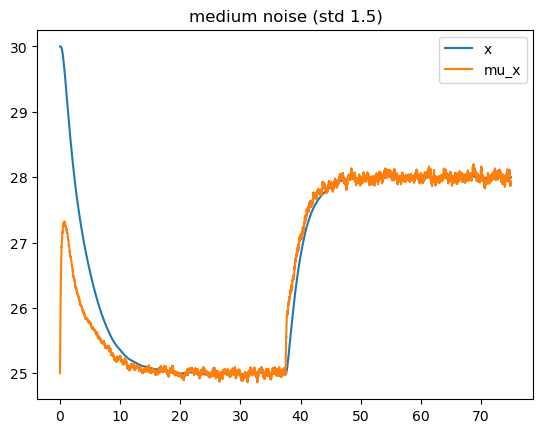

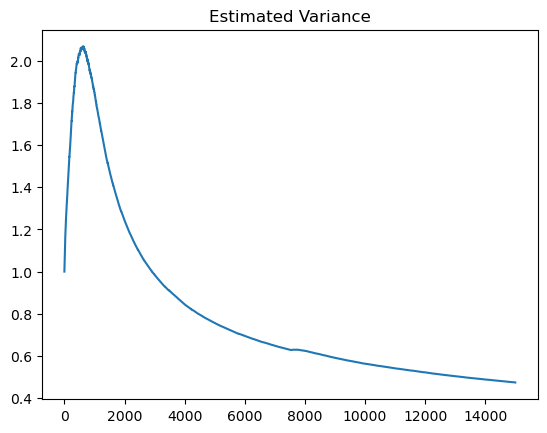

In [28]:
#plot 3

plt.figure()
plt.plot(time, x, label = "x")
plt.plot(time, mu, label = "mu_x")
plt.legend()
plt.title("medium noise (std 1.5)")
# plt.plot(mu_dot)

# plt.figure()
# plt.plot(x_dot, label= "xdot")
# plt.plot(mu_dot, label = "mudot")
# plt.legend()

# plt.figure()
# plt.plot(mu)

plt.figure()
#plt.plot(1/omega_z0)
plt.plot(1/omega_z0)
plt.title("Estimated Variance")


In [120]:
#script 4  Generalized coordinates with Action and Causal state updatebij 
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz, cholesky, sqrtm, inv

# Define time settings
T = 75
dt = 0.005
time = np.arange(0, T, dt)
N  = time.size

x = np.zeros(N)
x_dot = np.zeros(N)
y = np.zeros(N)
y_dot = np.zeros(N)
mu_x = np.zeros(N)
mu_x_dot = np.zeros(N)
u = np.zeros(N)
mu_v = np.zeros(N)
mu_v_dot = np.zeros(N)


omega_w0 = np.zeros(N)
omega_w1 = np.zeros(N)
omega_z0 = np.zeros(N)
omega_z1 = np.zeros(N)

omega_w0[0] = 5
omega_w1[0] = 5
omega_z0[0] = 5
omega_z1[0] = 5

alpha_mu_x = 1
alpha_mu_v = 1
alpha_u = 1
alpha_w = 0.1
alpha_z = 0.1

x[0] = 30
mu_x[0] = 25
mu_v[0] = 25
mu_prior = 25
mu_x_dot[0] = - mu_x[0] + mu_v[0]

D = np.array([[0,1],[0,0]])

PI_v = np.array([[1,0],[0,1]])

for i in np.arange(0,N-1):
    
    #generative process(in geval van wél aciton)
    x_dot[i] = u[i]  #np.random.randn(1)*0.5
    x[i+1] = x[i] + dt*x_dot[i]

    if i<0.5*N:
        y[i] = x[i] + np.random.randn(1)*3#*np.sin(10*1/N*i)
        y_dot[i] = x_dot[i] #+np.random.randn(1)*0.5
 
    else:
        mu_prior = 28
        y[i] = x[i]  + np.random.randn(1)*3#*np.sin(10*1/N*i)
        y_dot[i] = x_dot[i] #+np.random.randn(1)*0.5
    
   
   
    # #Set precision matrices for iteration    
    PI_w = np.diag([1,1])
    PI_z = np.diag([omega_z0[i],1])

    #prediction errors
    e_x = np.array([[mu_x_dot[i]], [0]]) - (np.array([[-mu_x[i]],[-mu_x_dot[i]]]) + np.array([[mu_v[i]],[0]]))
    e_y = np.array([[y[i]],[y_dot[i]]]) - np.array([[mu_x[i]],[mu_x_dot[i]]])
    

    #belief update
    dFdmu_x = np.array([[1,1],[0,1]]).T.dot(np.dot(PI_w,e_x)) - np.dot(np.identity(2),np.dot(PI_z,e_y))
    dmu_x = np.array([[mu_x_dot[i]], [0]]) - alpha_mu_x*dFdmu_x
    
    mu_x[i+1] = mu_x[i] + dt*dmu_x[0]
    mu_x_dot[i+1] = mu_x_dot[i] +dt*dmu_x[1]

    #causal state update
    e_v = np.array([[mu_v[i]],[0]]) - np.array([[mu_prior], [0]])
    dFdmu_v = np.array([[-1,0],[0,0]]).T.dot(np.dot(PI_w,e_x)) + PI_v.dot(e_v)
    dmu_v = -alpha_mu_v*dFdmu_v[0]
    mu_v[i+1] = mu_v[i] + dt*dmu_v[0]

    #action
    # if i > 0.2*N:
    u_dot = -np.array([0,1]).dot(PI_z).dot(e_y)
    u[i+1] = u[i] + dt*u_dot

    #   precision updating
    # dPI_w = alpha_w*0.5*(inv(PI_w) - np.diag(e_x.flatten())**2)
    dPI_z = alpha_z*0.5*(inv(PI_z) - np.diag(e_y.flatten())**2)
    # PI_w = PI_w + dt*dPI_w
    PI_z = PI_z + dt*dPI_z

    omega_w0[i+1] = PI_w[0,0]
    omega_w1[i+1] = PI_w[1,1]
    omega_z0[i+1] = PI_z[0,0]
    omega_z1[i+1] = PI_z[1,1]




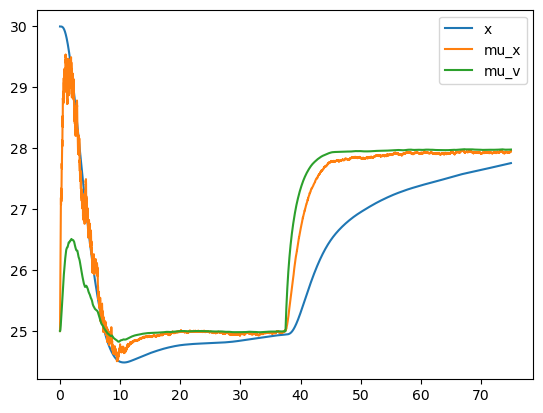

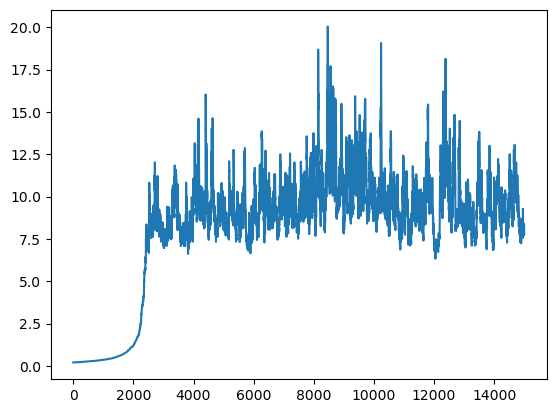

In [121]:
#plot 4

plt.figure()
plt.plot(time, x, label = "x")
plt.plot(time, mu_x, label = "mu_x")
plt.plot(time, mu_v, label = "mu_v")
plt.legend()
# plt.plot(mu_dot)

# plt.figure()
# plt.plot(x_dot)
# plt.plot(mu_x_dot, label = "mudot")
# plt.legend()

# plt.figure()
# plt.plot(mu)

plt.figure()
plt.plot(1/omega_z0)
# plt.plot(1/omega_z1)


In [ ]:
#script 5 Combining 1 with action

#script 1 basic AI
import numpy as np
from statistics import mean, variance, pstdev
import matplotlib.pyplot as plt
# Setting up the time data:
dt = 0.005; # integration step, average neuron resets 200 times per second
T = 250 + dt; # maximum time considered
t = np.arange(0,T,dt)
N= t.size #Amount of data points



def g_gp(x):

    t0=25
    return t0 -16 / (1 + np.exp(5-x/5))

def dg_gp(x):
    
    return -16/5* np.exp(5-x/5) / (np.exp(5-x/5)+1)**2



#initate arrays
mu_x = np.zeros(N)
mu = np.zeros(N)
e_x = np.zeros(N)
e_y = np.zeros(N)
eps_x = np.zeros(N)
eps_y = np.zeros(N)
y0 =np.zeros(N)
x0 = np.ones(N)*30
y =np.zeros(N)
x = np.zeros(N)
x_dot = np.zeros(N)
y_dot = np.zeros(N)
mu_dot = np.zeros(N)
u = np.zeros(N)
omega_x = np.zeros(N)
omega_y = np.zeros(N)
sigma_x = np.zeros(N)
sigma_y = np.zeros(N)
std = np.zeros(N)


omega_x = np.ones(N)*0.3
omega_y[0] = 5 
mu_v = 25
mu_x[0]= 30

x[0] = 30
x_dot[0] = 0

std_noise_x = 0.4
std_noise_y = 0.8

alpha_x = 1
alpha_y = 1
alpha_mu = 1
alpha_mux = 1
dmuxvec= [0]

for i in np.arange(0,N-1):
    
    # prior real depth: x == prior: mu_v == 30
   # x[i] = 30         # + np.random.randn(1)*std_noise_x       #x[i+1]  gebruiken   
    y0[i] = g_gp(x[i])   + np.random.randn(1)*std_noise_y*np.sin(10*1/N*i)  
    # if i<0.3*N:
    #     y[i] = g_gp(x[i])  # + np.random.randn(1)*std_noise_y
    
    # elif i<0.7*N:
    #     y[i] = g_gp(x[i])   + np.random.randn(1)*std_noise_y
    # else:
    #     y[i] = g_gp(x[i])   #+ np.random.randn(1)*std_noise_y
    sigma_x[i] =  1/omega_x[i]
    sigma_y[i] =  1/omega_y[i]
    
    eps_x[i] = mu_x[i] - mu_v    # Mu_x[0] = 25 and mu_v = 30 
    eps_y[i] = y0[i] - g_gp(mu_x[i]) # x = 30 so y(i) = g(30)

    # hidden stsate update
    dFdmu_x = eps_x[i]*omega_x[i] - dg_gp(mu_x[i]) * eps_y[i]*omega_y[i]
    dmu_x   = 0 - alpha_mux* dFdmu_x
    mu_x[i+1] = mu_x[i] + dt*dmu_x

   
    #precision update 
    #domega_x = alpha_x*(0.5*(1/omega_x[i] - e_x[i]**2))
    domega_y = alpha_y*(0.5*(1/omega_y[i] - eps_y[i]**2))
    #omega_x[i+1] = omega_x[i] + dt*domega_x
    omega_y[i+1] = omega_y[i] + dt*domega_y

   
    sigma_x[i+1] =1/ omega_x[i+1]
    sigma_y[i+1] =1/ omega_y[i+1]





    #generative process(in geval van wél aciton)
    x_dot[i] = u[i]  #np.random.randn(1)*0.5
    x[i+1] = x[i] + dt*x_dot[i]

    y[i] = x[i] #*np.sin(10*1/N*i)
    y_dot[i] = x_dot[i] #+ np.random.randn(1)*2
 

    #Set precision matrices for iteration
    # PI_w = np.diag([omega_w0[i],omega_w1[i]])
    PI_z = np.diag([1,1])
    PI_w = np.diag([1,1])
    # PI_z = np.diag([1,1])    


    #prediction errors
    e_x = np.array([[mu_dot[i]], [0]]) - (np.array([[-mu[i]],[-mu_dot[i]]])+np.array([[mu_x[i]],[0]]))
    e_y = np.array([[y[i]],[y_dot[i]]]) - np.array([[mu[i]],[mu_dot[i]]]) #- np.array([[5],[0]])
    

    #belief update
    dFdmu = np.array([[1,1],[0,1]]).T.dot(np.dot(PI_w,e_x)) - np.dot(np.identity(2),np.dot(PI_z,e_y))
    dmu = np.array([[mu_dot[i]], [0]]) - alpha_mu*dFdmu
    mu[i+1] = mu[i] + dt*dmu[0]
    mu_dot[i+1] = mu_dot[i] +dt*dmu[1]
 
    #action
    u_dot = -np.array([0,1]).dot(PI_z).dot(e_y)
    u[i+1] = u[i] + dt*u_dot
  









In [ ]:
print(x)

[30.         30.         30.         ... 25.03081153 25.0308231
 25.03083463]


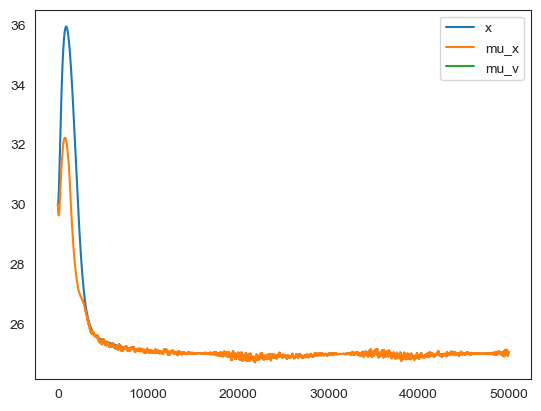

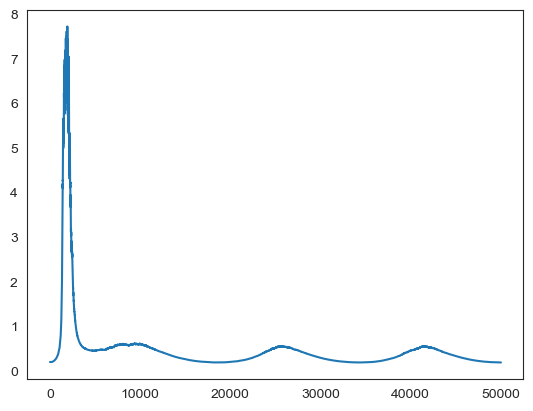

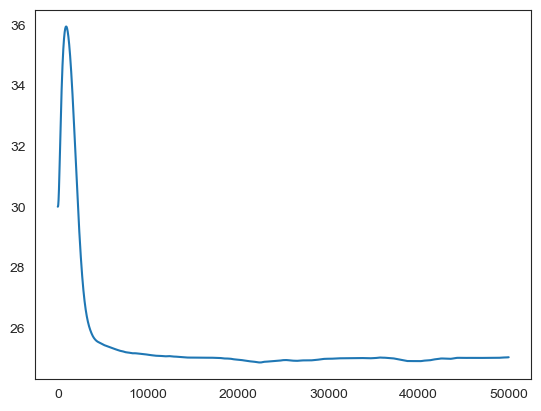

In [ ]:
#plot 5

plt.figure()
plt.plot(x, label = "x")
plt.plot(mu_x, label = "mu_x")
plt.plot(mu_v, label = "mu_v")
plt.legend()
# plt.plot(mu_dot)



plt.figure()
plt.plot(1/omega_y)

plt.figure()
plt.plot(x)
